# Exercise 2: Regression:

## Introducción:

En este ejercicio se realizó un ajuste lineal a los datos de **CalCofi** con el fin de predecir la variable "Temperatura en grados Celcius" (**T_degC**), para eso, se hizo una limpieza exaustiva de los datos mediante las funciones definidas en  el ejercicio anterior, ademas, se incluyen algunas funciones que permiten una visualización más simple de parámetros importantes de los datos.

Este ejercicio se basa en gran medida en el notebook publicado por *Harsh Chandrakar* en [Kaggle](https://www.kaggle.com/code/harshchandrakar/regression-to-predict-t-degc-from-scratch), donde resulve el mismo problema pero utilizando python.




### Paqueteria


In [1]:
import Pkg 

#=
Pkg.activate("new_env")
Pkg.Registry.rm("General")
Pkg.Registry.add("General")
Pkg.activate(".")
=#

Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("GLM")
Pkg.add("StatsModels")
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add("Flux")
Pkg.add("Optimisers")
Pkg.add("Measures")


import Pkg; Pkg.offline(true)


using CSV, DataFrames, Statistics, Plots, GLM, StatsModels, Distributions, StatsBase, Flux, Optimisers, Random, Measures

   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to 

### Lectura de CSV

Se lee el CSV 

In [21]:
# Obtenemos la ruta de la carpeta src
dir_src = @__DIR__
dir_base = joinpath(dir_src, "..")
dir_dat = joinpath(dir_base, "dat")
ruta_datos = joinpath(dir_dat, "bottle.csv")

bottle_df = DataFrame(CSV.File(ruta_datos));

println(first(bottle_df,10))

10×74 DataFrame
 Row │ Cst_Cnt  Btl_Cnt  Sta_ID       Depth_ID                           Depthm  T_degC    Salnty    O2ml_L    STheta    O2Sat     Oxy_µmol/Kg  BtlNum   RecInd  T_prec  T_qual   S_prec  S_qual   P_qual  O_qual  SThtaq   O2Satq  ChlorA    Chlqua  Phaeop    Phaqua  PO4uM     PO4q    SiO3uM    SiO3qu  NO2uM     NO2q    NO3uM     NO3q    NH3uM     NH3q    C14As1    C14A1p   C14A1q  C14As2    C14A2p   C14A2q  DarkAs    DarkAp   DarkAq  MeanAs    MeanAp   MeanAq  IncTim     LightP    R_Depth  R_TEMP    R_POTEMP  R_SALINITY  R_SIGMA   R_SVA     R_DYNHT   R_O2      R_O2Sat   R_SIO3    R_PO4     R_NO3     R_NO2     R_NH4     R_CHLA    R_PHAEO   R_PRES  R_SAMP   DIC1      DIC2      TA1       TA2       pH2       pH1       DIC Quality Comment 
     │ Int64    Int64    String15     String                             Int64   Float64?  Float64?  Float64?  Float64?  Float64?  Float64?     Int64?   Int64   Int64?  Int64?   Int64?  Int64?   Int64?  Int64?  Int64?   Int64?  Float64?  Int6

### Declaracion de funciones

Declaramos todas las funciones en una sola celda para organizar mejor

In [22]:

# Funcion para obtener columnas numericas
function num_cols(df)

    #= Obtenenos las columas numericas del df como todas aquellas que tienen tipos Union{Missing, Number}
    Hacemos eso ya que gran parte de los datos tienen datos missing, y la naturaleza de Julia define las 
    columnas con missgin como Union{Missing, T}
    
    Lo que se busca con esto es no omitir datos importantes. =#
    cols = [col for col in names(df) if eltype(df[!,col]) <: Union{Missing, Number}]
    #cols = [col for col in names(df) if eltype(df[!,col]) <: Number]
    return cols
end



# Funcion para hacer display de numero de columnas y filas
function dataShape(df)
    # Imprimimos no de col y no de filas
    println("Num of rows: $(size(df,1))")
    println("Num of cols: $(size(df,2))")
end



# Funcion para contar missing X columna
function count_missing(col)
    count(ismissing,col)
end



# Funcion para obtener el porcentaje de missing de cada columna
function missing_percentage(col)
    count_missing(col)/length(col)*100
end


# Funcion para imprimir nombre/ tipo / porcentaje de missing como una tabla
function insigth_display(df)
    insigth = DataFrame(
        "Name" => names(df),
        "Type" => eltype.(eachcol(df)),
        "miss_per" => [missing_percentage(col) for col in eachcol(df)]
    )
    println(insigth)
end



# Funcion para borrar columnas dado un umbral de porcentaje de missing
function deleteColumns(df, threshold)

    #aqui solo tengo una lista
    cols_to_delete = [col for col in names(df) if missing_percentage(df[!,col]) > threshold]

    #aqui las elimino de verdad
    select!(df, Not(cols_to_delete))
end



# Funcion para sacar la matriz de correlacion
function calculateCorrelation(df)

    numerical_columns = num_cols(df)
    #= Eliminamos las filas con missing en las columnas numéricas
    antes de calcular la matriz de correlación para evitar que los coeficientes sean nulos=#
    filtered_df = dropmissing(df[:, numerical_columns])  
    return cor(Matrix(filtered_df))


end

# Funcion para graficar un heatmat asociado a la matriz de correlacion
# La parte más importante de este heatmap es la  visualización de los 
# valores de correlacion dentro de la matriz para determinar los siguientes pasos y/o como 
# aplicar la funcion filterColumnsByCorrelation()
function displayCorrelation(df,saveplot::String,plotname::String,font_z::Int)

    # Volvemos a calcular estos parametros para reflejar el estado actual del df 
    correlation_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    xlabel = ylabel = string.(numerical_columns) 
    nrow, ncol = size(correlation_matrix)
    
    # Graficamos el heatmap
    plot_obj=heatmap(correlation_matrix, xticks=(1:ncol, xlabel), yticks=(1:nrow, ylabel),
        fill_z=correlation_matrix, xrotation=45)
    
    # Tamaño de la fuente 
    fontsize = font_z
    
    # Anotamos los valores de correlación en cada cajita
    ann = [(i, j, text(round(correlation_matrix[i, j], digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
    annotate!(ann, linecolor=:white)

    if saveplot == "yes"

        dir_src = @__DIR__
        dir_base = joinpath(dir_src, "..")
        dir_fig = joinpath(dir_base, "fig")
        savefig(joinpath(dir_fig, plotname))

    else
        return plot_obj
    end
    return plot_obj
end



# Funcion para quitar outliers 
function removeOutliersIQR(df)

    # Volvemos a calcular las col numericas
    numerical_columns = num_cols(df)
    # para cada una obtenemos el iqr y usamos un umbral de 1.5
    for col in numerical_columns
        q1, q3 = quantile(df[!,col],[0.25,0.75])
        iqr = q3 - q1

        low_lim = q1 - 1.5 * iqr
        upp_lim = q3 + 1.5 * iqr

        # actualizamos el df en cada iteracion
        df = filter(row -> low_lim <= row[col] <= upp_lim, df)
    end  
    return df  
end



# Funcion para eliminar filas con valores missing de una columna y convertir de tipo Union(missing, T) a solo T
function deleteRow(df,col)
   
    # Tomamos el tipo de la columna Union{missing,T} y reasignamos el tipo como solo T
    current_type = eltype(df[!, col])
    T = Base.nonmissingtype(current_type)
    # Ademas borramos las filas con missing
    dropmissing!(df,col)
    # Y convertimos el tipo 
    df[!, col] = convert(Vector{T}, df[!, col])
    
end

# Funcion para eliminar columnas dado un imbral y una relación
function filterColumnsByCorrelation(df::DataFrame, target::String, threshold::Float64, relation::Bool)
    # Calculamos la matriz de correlación y obtenemos los nombres de las columnas numéricas
    corr_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    
    # Verificamos si el target esta en la lista de col num, de otro modo termina la ejecución de la funcion
    if !(target in numerical_columns)
        println("La columna objetivo '$target' debe ser numérica y válida.")
        return
    end

    # Crear un diccionario para mapear los nombres de las columnas con la matriz de correlación
    corr_map = Dict(numerical_columns[j] => corr_matrix[j, findfirst(==(target), numerical_columns)] 
                    for j in 1:length(numerical_columns) if numerical_columns[j] != target)
    
    # Filtra las columnas en base al umbral y la relación
    for (key, val) in corr_map
        if relation == false && abs(val) <= abs(threshold)
            select!(df, Not(key))  # Eliminar la columna del DataFrame
        elseif relation == true && val >= threshold
            select!(df, Not(key))  # Eliminar la columna del DataFrame
        end
    end

    return df
end

# Funcion para tomar una columna categorica y obtener información cuantitativa
function encoder(df::DataFrame, col::String)

     # Creamos una nueva columan _Encoded
     encoded_col = Symbol(col * "_Encoded")
     # hacemos una lista de los valores unicos de la columna
     categories = unique(df[!, Symbol(col)])  
     # a cada categoria le asignamos un valor numerico
     category_dict = Dict(category => i for (i, category) in enumerate(categories))  
     # Imprimimos la nueva clasificacion sobre la nueva columna 
     df[:, encoded_col] = [category_dict[x] for x in df[!, Symbol(col)]]  
     return df  
end

encoder (generic function with 1 method)

### Menu de funciones:

**Funcion para obtener columnas numericas**<br>
num_cols(df)

**Funcion para hacer display de numero de columnas y filas**<br>
dataShape(df)

**Funcion para contar missing X columna**<br>
count_missing(col)

**Funcion para obtener el porcentaje de missing de cada columna**<br>
missing_percentage(col)


**Funcion para imprimir columnas / tipo / % de missing**<br>
insigth_display(df) 

**Funcion para borrar columnas dado un umbral de porcentaje de missing**<br>
deleteColumns(df, threshold)

**Funcion para sacar la matriz de correlacion**<br>
calculateCorrelation(df)

**Funcion para hacer heatmaps con anotaciones**<br>
displayCorrelation(df,saveplot::String,plotname::String,font_z::Int)

**Funcion para quitar outlier**<br>
removeOutliersIQR(df)

**Funcion para eliminar filas con valores missing de una columna, y convertimos de tipo Union(missing, T) a solo T**<br>
deleteRow(df,col)

**Funcion para eliminar filas en funcion de un umbral de correlacion**<br>
filterColumnsByCorrelation(df::DataFrame, target::String, threshold::Float64, relation::Bool)

**Funcion para obtener informacion numerica de una columna categórica**<br>
encoder(df::DataFrame, col::String)





### Comenzamos el EDA

Se observa al hacer **insigth_display()** sobre los datos que el analisis se enfrenta a tres problemas fundamentales:

1. El alto número de variables.
2. El alto porcentaje de *missing* en gran parte de las columnas.
3. El tipo **Union{Missing, T}** para todas las columnas con datos tipo *missing*.<br><br>

Nos enfrentaremos a estos problemas mediente la reducción de dimensionalidad lograda eliminando todas aquellas columnas que superen un umbral de datos nulos, y por medio de la redefinición del tipo de los datos gracias a la funcion **deleteRow()**.

In [23]:

dataShape(bottle_df)
println()
insigth_display(bottle_df)


Num of rows: 864863
Num of cols: 74

74×3 DataFrame
 Row │ Name                 Type                      miss_per 
     │ String               Type                      Float64  
─────┼─────────────────────────────────────────────────────────
   1 │ Cst_Cnt              Int64                      0.0
   2 │ Btl_Cnt              Int64                      0.0
   3 │ Sta_ID               String15                   0.0
   4 │ Depth_ID             String                     0.0
   5 │ Depthm               Int64                      0.0
   6 │ T_degC               Union{Missing, Float64}    1.2676
   7 │ Salnty               Union{Missing, Float64}    5.47532
   8 │ O2ml_L               Union{Missing, Float64}   19.5016
   9 │ STheta               Union{Missing, Float64}    6.09218
  10 │ O2Sat                Union{Missing, Float64}   23.54
  11 │ Oxy_µmol/Kg          Union{Missing, Float64}   23.5407
  12 │ BtlNum               Union{Missing, Int64}     86.2791
  13 │ RecInd              

Eliminamos todas las columas con un porcentajde missing mayor a 7% mediante **deleteColumns(bottle_df,7)** y volvemos a hacer **insigth_display**.

In [24]:
deleteColumns(bottle_df,7);
insigth_display(bottle_df)


24×3 DataFrame
 Row │ Name        Type                     miss_per 
     │ String      Type                     Float64  
─────┼───────────────────────────────────────────────
   1 │ Cst_Cnt     Int64                     0.0
   2 │ Btl_Cnt     Int64                     0.0
   3 │ Sta_ID      String15                  0.0
   4 │ Depth_ID    String                    0.0
   5 │ Depthm      Int64                     0.0
   6 │ T_degC      Union{Missing, Float64}   1.2676
   7 │ Salnty      Union{Missing, Float64}   5.47532
   8 │ STheta      Union{Missing, Float64}   6.09218
   9 │ RecInd      Int64                     0.0
  10 │ T_prec      Union{Missing, Int64}     1.2676
  11 │ S_prec      Union{Missing, Int64}     5.47532
  12 │ NH3q        Union{Missing, Int64}     6.54023
  13 │ C14A1q      Union{Missing, Int64}     1.87984
  14 │ C14A2q      Union{Missing, Int64}     1.87775
  15 │ DarkAq      Union{Missing, Int64}     2.82392
  16 │ MeanAq      Union{Missing, Int64}     2.82403
 

Aplicamos la funcion **deleteRow()** al *target* **T_degC** para eliminar la dependencia del tipo **Union{Missing, T}**, e imprimimos el primer *Heatmap* para estudiar gráficamente el estado de la correlación de las variables y obtenemos información relevante de la funcion encoder al aplicarla a las columnas **Sta_ID** y **Depth_ID**


10×26 DataFrame
 Row │ Cst_Cnt  Btl_Cnt  Sta_ID       Depth_ID                           Depthm  T_degC    Salnty    STheta    RecInd  T_prec  S_prec  NH3q    C14A1q  C14A2q  DarkAq  MeanAq  R_Depth  R_TEMP    R_POTEMP  R_SALINITY  R_SIGMA   R_SVA     R_DYNHT   R_PRES  Sta_ID_Encoded  Depth_ID_Encoded 
     │ Int64    Int64    String15     String                             Int64   Float64?  Float64?  Float64?  Int64   Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Float64  Float64?  Float64?  Float64?    Float64?  Float64?  Float64?  Int64   Int64           Int64            
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │       1        1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0…       0     10.5     33.44     25.649       3   

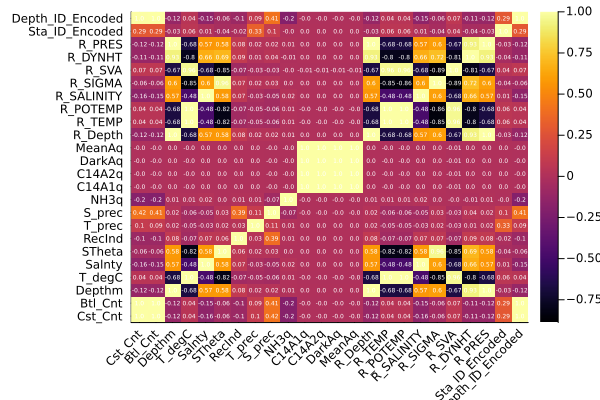

In [25]:
encoder(bottle_df, "Sta_ID")
encoder(bottle_df, "Depth_ID")

# Aqui no podemos aplicar el mismo paso que en kaggle, pues la funcion "quantiles" no esta definida para 
# columnas con valores nulos por lo que dejaremos ese paso para el final
# removeOutliersIQR(bottle_df)
println(first(bottle_df,10))

deleteRow(bottle_df,"T_degC");
insigth_display(bottle_df)
displayCorrelation(bottle_df,"yes","Heatmap_1",4)



Ya que vamos a hacer una regresion lineal, es conveniente eliminar las columnas con un coeficiente de correlacion bajo con la columna 
*target*, ademas, es necesario eliminar las columnas que tengan un coeficiente de correlación alto entre ellas, ya que puede llevar a 
sobre ajuste del modelo.

In [26]:
filterColumnsByCorrelation(bottle_df, "T_degC",0.1,false)


# Recorremos todas las variables númericas para verificar cuales son las que tienen un coeficiente de correlacion alto entre si
# Aqui a diferencia de Chandrakar eliminamos de manera directa todas las columnas que tengan una alta correlacion con ellas mismas.

nums = num_cols(bottle_df)
println("Columnas a buscar con alta correlacion: $nums")
# Iterar sobre todas las columnas
for i in 1:length(nums)
     # Recalcular nums
    if isempty(nums)
        break
    end
    col = nums[i]  # Tomar la primera columna
    println("Analizando columna: $col")
    filterColumnsByCorrelation(bottle_df,col,0.85,true)
end



Columnas a buscar con alta correlacion: ["Depthm", "T_degC", "Salnty", "STheta", "R_Depth", "R_TEMP", "R_POTEMP", "R_SALINITY", "R_SIGMA", "R_SVA", "R_DYNHT", "R_PRES"]
Analizando columna: Depthm
Analizando columna: T_degC
Analizando columna: Salnty
Analizando columna: STheta
Analizando columna: R_Depth
La columna objetivo 'R_Depth' debe ser numérica y válida.
Analizando columna: R_TEMP
La columna objetivo 'R_TEMP' debe ser numérica y válida.
Analizando columna: R_POTEMP
La columna objetivo 'R_POTEMP' debe ser numérica y válida.
Analizando columna: R_SALINITY
La columna objetivo 'R_SALINITY' debe ser numérica y válida.
Analizando columna: R_SIGMA
La columna objetivo 'R_SIGMA' debe ser numérica y válida.
Analizando columna: R_SVA
La columna objetivo 'R_SVA' debe ser numérica y válida.
Analizando columna: R_DYNHT
La columna objetivo 'R_DYNHT' debe ser numérica y válida.
Analizando columna: R_PRES
La columna objetivo 'R_PRES' debe ser numérica y válida.


Volvemos a dar un vistaso a al estado actual de los datos.

In [27]:
dataShape(bottle_df)


plot=displayCorrelation(bottle_df,"yes","Heatmap_2",8)
display(plot)
insigth_display(bottle_df)


Num of rows: 853900
Num of cols: 6
6×3 DataFrame
 Row │ Name      Type                     miss_per 
     │ String    Type                     Float64  
─────┼─────────────────────────────────────────────
   1 │ Sta_ID    String15                  0.0
   2 │ Depth_ID  String                    0.0
   3 │ Depthm    Int64                     0.0
   4 │ T_degC    Float64                   0.0
   5 │ Salnty    Union{Missing, Float64}   4.64375
   6 │ STheta    Union{Missing, Float64}   4.88652


Ya que solo tenemos dos columnas con aprox 5% de porcentaje de missing, podemos borrar todas las filas con datos faltantes.


In [28]:

for col in names(bottle_df)
    if missing_percentage(bottle_df[:, col]) != 0
        deleteRow(bottle_df,col)
    end
end
describe(bottle_df)

# Volvemos a barrer a los outliers
removeOutliersIQR(bottle_df)
describe(bottle_df)



6×7 DataFrame
 Row │ variable  mean     min                                median   max      ⋯
     │ Symbol    Union…   Any                                Union…   Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Sta_ID             001.0 168.0                                 176.7 03 ⋯
   2 │ Depth_ID           19-4903CR-HY-060-0930-05400560-0…           20-1611S
   3 │ Depthm    222.435  0                                  125.0    5351
   4 │ T_degC    10.8479  1.44                               10.1     31.14
   5 │ Salnty    33.8424  28.431                             33.8692  37.034   ⋯
   6 │ STheta    25.8194  20.934                             25.996   250.784
                                                               3 columns omitted

# A partir de aqui comenzamos con el ajuste de los modelos de regresión lineal.

Para evaluar el rendimiento del modelo, vamos a usar tres opciones diferentes y comparar los resultados.<br><br>

1. Modelo convencional, mediante la biblioteca **GLM** haciendo uso de la funcion model = lm(formula, df) y refinando el ajuste mediante parametros como la **P** y la estadística **T**.
2. Modelo con redes profundas mediante la biblioteca **Flux**.
3. Traduciendo el algoritmo usado en el articulo de *Harsh Chandrakar* en [Kaggle](https://www.kaggle.com/code/harshchandrakar/regression-to-predict-t-degc-from-scratch).


## Primera parte (GML):

Definimos 2 funciones, una para evaluar parametros y rendimiento del modelo, y una para ajustar el modelo mismo.



De nuevo, definimos todas nuestras funciones en una sola celda para organizar mejor el código.

In [29]:


# Funcion para obtener las variables que no cumplan con los criterios de P y T
function var_validator(model, model_df)
    
    # Aqui obtenemos el valor critico para poder hacer la comparacion de t
    
    dof = dof_residual(model)
    alpha = 0.05
    t_dist = TDist(dof)
    t_crit = quantile(t_dist, 1 - alpha/2)

    println("El valor crítico para dof = $dof y alpha = $alpha es $t_crit")
    println()

    # Aqui evaluamos sobre las variables independientes del modelo en terminos de t y P para ver cuales no son significativas

    unsig_cols = []

    for row in eachrow(model_df)
        if abs(row.t) < t_crit || row.P > 0.05
            println("Variable no significativa: ", row.Name, " t_stad: ", row.t, " p_val: ", row.P)
            push!(unsig_cols, row.Name)
        end
    end

    # Retornamos las variables no significativas para poder eliminarlas de numerical_columns y volver a ajustar el modelo
return unsig_cols    
end

# Creamos una strcutura para guardar los resultados de adjustmodel
struct ModelResults
    model 
    model_df
    unsig_cols
end

numerical_columns = num_cols(bottle_df)

# Funcion que ajusta al modelo 
function adjustmodel(df, target, num_cols::Vector{String})
    # Eliminamos a la variable objetivo de las las columnas numericas para ajustar el modelo
    filter!(col -> col != target, num_cols)  
    formula = Term(Symbol(target)) ~ foldl((a, b) -> a + b, Term.(Symbol.(num_cols)))  
    model = lm(formula, df)  # Ajustar el modelo
    table = coeftable(model)
    model_df = DataFrame(table)
    rename!(model_df,"Pr(>|t|)" => "P")

    # Llamamos a la funcion var_validator() 
    unsig_cols = var_validator(model, model_df)

    return ModelResults(model,model_df, unsig_cols)
end

adjustmodel (generic function with 1 method)

### Menu de funciones:

**Funcion para obtener las variables que no cumplan con los criterios de P y T**<br>
var_validator(model, model_df)

**Funcion que ajusta al modelo**<br>
adjustmodel(df, target::String, num_cols::Vector{String})

Usamos la funcion **adjustmodel()** una primera ves para obtener informacion relevante dentro de **unsig_cols**, despues, iniciamos un ciclo *While* para refinar a la lista de columnas numericas sobre las que ajustamos el modelo hasta que la variable **unsig_cols** (la que seguimos obteniendo de manera continua) quede vacia.

In [30]:
t_model = @elapsed begin

    # Ajustamos el modelo una primera ves de manera manual
    result = adjustmodel(bottle_df, "T_degC", numerical_columns)
    unsig_cols = result.unsig_cols

    # Entramos a un ciclo While que corre mientras haya columnas no significativas
    while !isempty(unsig_cols)
        # Eliminamos las columnas no significativas de la lista de columnas
        setdiff!(numerical_columns, unsig_cols)
    
        # Volvemos a ajustar el modelo con la nueva lista de columnas
        result = adjustmodel(bottle_df, "T_degC", numerical_columns)
    
        # Extraemos las columnas no significativas nuevamente
        unsig_cols = result.unsig_cols
    end
end

# Al final del ciclo, tenemos el resultado final
model_df = result.model_df
model = result.model


El valor crítico para dof = 812170.0 y alpha = 0.05 es 1.9599669054518833



StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T_degC ~ 1 + Depthm + Salnty + STheta

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  43.9957      0.209373     210.13    <1e-99  43.5853      44.4061
Depthm       -0.00449304  9.91469e-6  -453.17    <1e-99  -0.00451247  -0.00447361
Salnty        0.988245    0.00675994   146.19    <1e-99   0.974996     1.00149
STheta       -2.54045     0.00269576  -942.39    <1e-99  -2.54574     -2.53517
─────────────────────────────────────────────────────────────────────────────────

Creamos dos graficos, **Predicción vs Observación** y **Residuos vs Predicción**, estos no se imprimen sobre el reporte ya que la compilación toma demasiado tiempo; en ves de eso se guardan como archivos **.png**.

In [31]:


# Gráfico de dispersión que compara T_degC real vs. T_degC estimada
comp_plor = Plots.scatter(bottle_df.T_degC, predict(model), label="Predicción vs Observación", xlabel="Valores Observados (T_degC)", ylabel="Valores Predichos", legend=:topright, ylims=(-10, 35))
# Añadimos la linea X=Y, como referencia 
Plots.plot!([0, 35],[-10, 35],label="x = y", linestyle=:dash, color=:red)
dir_src = @__DIR__
dir_base = joinpath(dir_src, "..")
dir_fig = joinpath(dir_base, "fig")
savefig(joinpath(dir_fig, "comparacion.png"))


# Calculamos valores residuales
T_degC_aligned = bottle_df.T_degC[1:length(predict(model))]
residuals = bottle_df.T_degC[1:length(predict(model))] .- predict(model)

# Gráfico de dispersión de residuos vs predicciones
res_plot = Plots.scatter(predict(model), residuals , label="Residuos vs Predicción", xlabel="Valores Predichos", ylabel="Residuos", legend=:topright)
savefig(joinpath(dir_fig, "residuals.png"))




"c:\\Users\\USER\\Desktop\\julia\\src\\Ejercicios_terminados\\Ex_2\\fig\\residuals.png"

## Segunda parte (Flux):

Aqui en ves de definir funciones, usamos las propias de la libreria **Flux**. El mal ajuste de este modelo puede deverse a mi poca experiencia con esta libreria y tipo de entrenamiento, pero aún así quise incluir esta parte en la tarea para poder comparar sobre los resultados que obtuve y los de **Kaggle**.<br><br>

Tambien hay que considerar que **Flux** permite un nivel profundo de personalización de los modelos, por lo que el desconocimiento del uso de la libreria y de los parámetros puede llevar a un desajuste.

In [32]:
t_flux = @elapsed begin
    
    # Obtenemos las columnas numéricas del df y excluimos a T_degC
    numerical_columns = num_cols(bottle_df)
    # De nuevo separamos el tarjet de la lista de variables independientes 
    numerical_columns = setdiff(numerical_columns, "T_degC")
    target_column = "T_degC"

    # Definimos la matriz de variables independientes X y el vector objetivo Y
    X = Matrix(select(bottle_df, numerical_columns))
    Y = bottle_df[:, target_column]

    # Transponemos X y nos aseguramos que Y sea un vector
    X = X'
    Y = vec(Y)

    # Estandarizamos X y Y para que tengan media 0 y desviación estándar 1 y convertimos a Float32
    X = Float32.((X .- mean(X, dims=2)) ./ std(X, dims=2))
    Y = Float32.((Y .- mean(Y)) / std(Y))

    # Dividimos del conjunto de datos en entrenamiento (80%) y prueba (20%)
    using Random
    Random.seed!(123)  
    # Definimos el numero de muestras como el número de filas de la matriz X
    n = size(X, 2)  
    train_idx = randperm(n)[1:round(Int, 0.8 * n)]
    test_idx = setdiff(1:n, train_idx)

    X_train = X[:, train_idx]
    Y_train = Y[train_idx]
    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    # Definimos las dimensiones del modelo
    modelo = Chain(
        Dense(size(X, 1), 32, relu),  # Capa oculta con 32 neuronas y activación ReLU
        Dense(32, 16, relu),          # Otra capa oculta con 16 neuronas
        Dense(16, 1)                  # Capa de salida
    )  

    # Definimos la función de pérdida
    loss(x, y) = Flux.mse(vec(modelo(x)), y)

    # Usamos el optimizador ADAM 
    opt = ADAM(0.0001)

    # Entrenamiento del modelo con un criterio de parada
    last_loss = Inf
    last_test_loss = Inf
    max_epochs = 10000
    tolerance = 1e-6

    for epoch in 1:max_epochs
        try
            # Calculamos los gradientes manualmente usando los datos de entrenamiento
            grads = gradient(() -> loss(X_train, Y_train), Flux.trainable(modelo))
            # Aplicamos el optimizador
            Flux.Optimise.update!(opt, Flux.trainable(modelo), grads)
        
            # Calculamos la pérdida en entrenamiento y prueba
            train_loss = loss(X_train, Y_train)
            test_loss = loss(X_test, Y_test)
        
            # Imprimimos el progreso
            println("Epoch: $epoch, Pérdida entrenamiento: $train_loss, Pérdida prueba: $test_loss")
        
            # Early stopping: detener si la pérdida de prueba deja de mejorar
            if epoch > 10 && test_loss > last_test_loss
                println("Entrenamiento detenido: la pérdida de prueba aumentó.")
                break
            end
        
            # Criterio de parada si la pérdida no mejora significativamente
            if abs(last_loss - train_loss) < tolerance
                println("Entrenamiento detenido: mejora insignificante en la pérdida.")
                break
            end

            # Actualizamos la última pérdida registrada
            last_loss = train_loss
            last_test_loss = test_loss

        # Manejo de errores
        catch e
            println("Error en la iteración $epoch: ", e)
            println("Dimensiones de entrada: ", size(X_train))
            println("Dimensiones de salida esperada: ", size(Y_train))
            break
        end
    end

    # Obtenemos nuestra variable predicha en términos del modelo final (usando la X completa)
    Y_predicted = vec(modelo(X))
end



# Gráfica comparativa entre el modelo y los datos predichos
fig_1 = scatter(
    Y,
    Y_predicted,
    label="Predicción vs Observación",
    xlabel="Valores Observados (T_degC)",
    ylabel="Valores Predichos",
    legend=:topright,
    ylims=(-5, 15)
)

plot!(Y, Y, linestyle=:dash, label="Perfect Fit (y=x)", color=:red)
savefig(joinpath(dir_fig, "comparacion_flux.png"))


# Gráficamos los valores residuales
fig_2 = scatter(
    Y - Y_predicted,
    Y_predicted,
    label="Valores residuales",
    xlabel="Residuos",
    ylabel="Valores Predichos",
    legend=:topright
)

savefig(joinpath(dir_fig, "residuals_flux.png"))






Error en la iteración 1: MethodError(var"#62#63"(), ((layers = (Dense(4 => 32, relu), Dense(32 => 16, relu), Dense(16 => 1)),),), 0x000000000000698a)
Dimensiones de entrada: (4, 649739)
Dimensiones de salida esperada: (649739,)


"c:\\Users\\USER\\Desktop\\julia\\src\\Ejercicios_terminados\\Ex_2\\fig\\residuals_flux.png"

## Tercera parte (Kaggle / Manual):

A partir de aquí, traduciremos de Python a Julia el código de ajuste de *Harsh Chandrakar* en [Kaggle](https://www.kaggle.com/code/harshchandrakar/regression-to-predict-t-degc-from-scratch).<br><be>



In [33]:
# En esta primera sección de su codigo, Chandrakar define las funciones nesesarias
# para ejustar sus parametros de entrenamiento

t_kaggle_1 = @elapsed begin

    # Funcion para inicializar los pesos w y sesgos b para el modelo
    function init_params(n_features)
        W = randn(n_features) * 0.01
        b = 0.0
        return W, b
    end

    # Funcion para calcular la salida del modelo como una recta de tipo y = mx + b
    function compute(W, b, X)
        return X * W .+ b
    end

    # Funcion de perdida
    # Aqui se esta definiendo la funcion de perdida como el error cuadratico medio de manera manual
    # no usamos una implementacion ya definida en Julia para maneternos fieles al codigo de Chandrakar
    function loss(y_true, y_pred)
        return mean((y_true .- y_pred) .^ 2)
    end

    # Funcion para actualizar los parámetros con el descenso del gradiente
    function update_params(W, b, learning_rate, dw, db)
        W .-= learning_rate .* dw
        b -= learning_rate * db
        return W, b
    end

    # Funcion para normalizar los datos
    function normalize(X)
        X_mean = mean(X, dims=1)
        X_std = std(X, dims=1)
        X_normalized = (X .- X_mean) ./ X_std
        return X_normalized, X_mean, X_std
    end

    # Funcion para entrenar el modelo
    function train(X, y, learning_rate, epochs, tolerance=1e-4, decay=0.99, reg_lambda=0.001)
        # Primero se normalizan los datos
        X, X_mean, X_std = normalize(X)
        # Ajustes sobre el tipo
        X_poly = convert(Array{Float64}, X)
        y = convert(Array{Float64}, y)
    
        # Inicializacion de parametros
        W, b = init_params(size(X_poly, 2))
        prev_loss = Inf
    
        # Iteramos sobre n epocas
        for i in 1:epochs

            # Comenzamos a definir el modelo y aplicar la func de perdida
            y_pred = compute(W, b, X_poly)
            current_loss = loss(y, y_pred)
        
            # Se agrega regularización L2
            reg_loss = current_loss + reg_lambda * sum(W .^ 2)
        
            # Se calcula el gradiente sobre el peso y el sesgo
            dw = (2 .* (X_poly' * (y_pred .- y)) .+ 2 .* reg_lambda .* W) / size(X_poly, 1)
            db = 2 * sum(y_pred .- y) / size(X_poly, 1)
        
            # Actualizamos parametros y reducimos la tasa de aprendizaje
            W, b = update_params(W, b, learning_rate, dw, db)
            learning_rate *= decay
        
            # Criterio de parada similar al que usamos en la parte de flux
            if abs(prev_loss - reg_loss) < tolerance
                println("Early stopping at epoch $i with loss $reg_loss")
                break
            end
        
        
            prev_loss = reg_loss
        
            if i % 100 == 0
                println("Epoch $i, Loss: $reg_loss")
            end
        end
        return W, b, X_mean, X_std
    end

    # Funcion para realizar predicciones con los parametros ajustados
    function predictor(X, W, b; X_mean=nothing, X_std=nothing)
        if X_mean != nothing && X_std != nothing
            X = (X .- X_mean) ./ X_std
        end
        X_poly = X
        return compute(W, b, X_poly)
    end

    # Funcion para calcular R^2
    function r_squared(y_true, y_pred)
        ss_total = sum((y_true .- mean(y_true)) .^ 2)
        ss_residual = sum((y_true .- y_pred) .^ 2)
        return 1 - (ss_residual / ss_total)
    end

    # Funcion para calcular el porcentaje de coincidencias
    function match_percentage(y_true, y_pred, tolerance=0.1)
        differences = abs.(y_true .- y_pred)
        within_tolerance = differences .<= (tolerance .* abs.(y_true))
        return mean(within_tolerance) * 100
    end
end


0.0005189

In [34]:
# Parte del preprosesamiento de los datos
# Aqui Chandrakar toma los datos desordenados para definir el conjunto de entrenamiento y validacion

t_kaggle_2 = @elapsed begin


    # Función para dividir en conjuntos de entrenamiento y prueba
    function train_test_split(X::DataFrame, y::Vector, test_size::Float64=0.2)
        split_index = Int(floor(size(X, 1) * (1 - test_size)))
    
        X_train = X[1:split_index, :]
        X_test = X[split_index+1:end, :]
        y_train = y[1:split_index]
        y_test = y[split_index+1:end]
    
        return X_train, X_test, y_train, y_test
    end

    # Funcion para desordenar el DF
    function shuffle_dataframe(df::DataFrame, seed::Int64=42)
        Random.seed!(seed)
        shuffled_df = df[shuffle(1:size(df, 1)), :]
        return shuffled_df
    end

    bottle_df_shuffled = shuffle_dataframe(bottle_df, 42)

    # Definir X e y

    numerical_columns = num_cols(bottle_df)  
    numerical_columns = setdiff(numerical_columns, "T_degC") 

    X = select(bottle_df_shuffled, numerical_columns)
    y = bottle_df_shuffled[:, :T_degC]

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2)

end


0.1564268

In [35]:
# Finalmente aqui entrena el modelo mediante los parametros y conjuntos 
# definidos anteriormente

t_kaggle_3 = @elapsed begin

    # Convertimos la X a una matriz
    X_train_matrix = Matrix(X_train) 
    X_test_matrix = Matrix(X_test) 

    # Convertimos el tarjet a vectores
    y_train_vector = convert(Vector{Float64}, y_train)
    y_test_vector = convert(Vector{Float64}, y_test)

    # Entrenamos el modelo 
    W, b, X_mean, X_std = train(X_train_matrix, y_train_vector, 0.1, 1000)

    # Verificamos que X_mean y X_std sean vectores y no matrices
    println("X_mean: ", typeof(X_mean), " tamaño: ", size(X_mean))  # Debería ser Vector{Float64}
    println("X_std: ", typeof(X_std), " tamaño: ", size(X_std))  # Debería ser Vector{Float64}

    # Realizamos predicciones en el conjunto de prueba
    y_pred = predictor(X_test_matrix, W, b; X_mean=X_mean, X_std=X_std)

    # Imprimimos el coeficiente R²
    println("R-squared: ", r_squared(y_test_vector, y_pred))

    # Imprimimo el porcentaje de coincidencia con una tolerancia de 0.1
    println("Match percentage with tolerance of 0.1: ", match_percentage(y_test_vector, y_pred, 0.1))

end


Epoch 100, Loss: 0.058684036452888874
Early stopping at epoch 193 with loss 0.030308247249947497
X_mean: Matrix{Float64} tamaño: (1, 4)
X_std: Matrix{Float64} tamaño: (1, 4)
R-squared: 0.9986875240078674
Match percentage with tolerance of 0.1: 99.57521470126512


3.2422253

In [36]:
# Por último Chandrakar define sus propias funciones para la presentación gráfica de sus datos

# Funcion para graficar 'Actual vs. Predicted'
function plot_actual_vs_predicted(y_true::Vector{Float64}, y_pred::Vector{Float64})
    # Creamos un Df con lo datos de interes
    data = DataFrame(Actual=y_true, Predicted=y_pred)
    
    # Gráfico de dispersión (scatter plot)
    scatter(data.Actual, data.Predicted, 
        label="Predicted vs Actual", 
        xlabel="Actual", 
        ylabel="Predicted", 
        legend=false, 
        color=:blue,
        ylims=(0,25),
        xlims=(0,25))

    # Línea de predicción (y = x)
    plot!([minimum(y_true), maximum(y_true)], 
          [minimum(y_true), maximum(y_true)], 
          color=:red, 
          lw=2, 
          label="Perfect prediction")

    title!("Actual vs Predicted in degree")
    dir_src = @__DIR__
    dir_base = joinpath(dir_src, "..")
    dir_fig = joinpath(dir_base, "fig")
    savefig(joinpath(dir_fig, "comparacion_kaggle.png"))
    
end


# Función para graficar 'Residuals vs. Predicted' con líneas de tolerancia
function plot_residuals_with_tolerance(y_true::Vector{Float64}, y_pred::Vector{Float64}, tolerance::Float64=0.1)
    # Calcular residuos
    residuals = y_true .- y_pred
    
    # Creamos un Df con lo datos de interes
    data = DataFrame(Predicted=y_pred, Residuals=residuals)

    # Gráfico de dispersión (scatter plot) de los residuos
    scatter(data.Predicted, data.Residuals, 
        label="Residuals vs Predicted", 
        xlabel="Predicted", 
        ylabel="Residuals", 
        legend=false, 
        color=:green, 
        ylims=(0,3),
        xlims=(0,30))

    # Línea de residuo 0
    plot!([minimum(y_pred), maximum(y_pred)], 
          [0, 0], 
          color=:red, 
          lw=2, 
          label="Zero residual line")

    # Líneas de tolerancia superior e inferior
    upper_tolerance = tolerance .* abs.(y_true)
    lower_tolerance = -tolerance .* abs.(y_true)
    
    plot!([minimum(y_pred), maximum(y_pred)], 
          [mean(upper_tolerance), mean(upper_tolerance)], 
          color=:blue, 
          lw=2, 
          linestyle=:dash, 
          label="Upper Tolerance")

    plot!([minimum(y_pred), maximum(y_pred)], 
          [mean(lower_tolerance), mean(lower_tolerance)], 
          color=:orange, 
          lw=2, 
          linestyle=:dash, 
          label="Lower Tolerance")

    title!("Predicted vs Residuals")
    dir_src = @__DIR__
    dir_base = joinpath(dir_src, "..")
    dir_fig = joinpath(dir_base, "fig")
    savefig(joinpath(dir_fig, "residuals_kaggle.png"))    
end


# Llamar a las funciones con y_test y y_pred
plot_actual_vs_predicted(y_test_vector, y_pred)
plot_residuals_with_tolerance(y_test_vector, y_pred)


"c:\\Users\\USER\\Desktop\\julia\\src\\Ejercicios_terminados\\Ex_2\\fig\\residuals_kaggle.png"

## Tiempo

Al tomar los parametros de tiempo obtenidos de usar **@elapsed** podemos comparar el tiempo que le tomo a cada modelo entrenar y asi poder hablar del rendmiento de cada uno en terminos del ajuste vs. la complejidad asociada. Aqui nos referimos a **Manual** como el ajusto que hicimos mediante **GLM** y el uso de los parametros **P** y **T**.

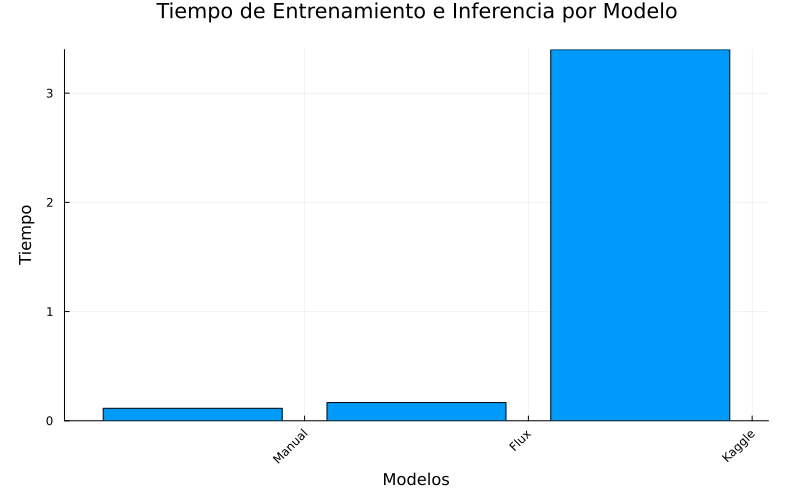

3×2 DataFrame
 Row │ Name    Time (seg) 
     │ String  Float64    
─────┼────────────────────
   1 │ Manual    0.114001
   2 │ Flux      0.166694
   3 │ Kaggle    3.39917


In [37]:
# Definimos un vector para guardar tiempos de ejecucion
tiempos = [t_model, t_flux, t_kaggle_1 + t_kaggle_2 + t_kaggle_3]
model_names = ["Manual", "Flux", "Kaggle"]
posiciones = 1:length(model_names)

# Crear un DataFrame
insigth = DataFrame(
    "Name" => model_names,
    "Time (seg)" => tiempos
)
println(insigth)

# Usar la biblioteca de gráficos GR
gr()

# Crear la gráfica de barras correctamente
time_gra = bar(
    model_names, tiempos,
    title = "Tiempo de Entrenamiento e Inferencia por Modelo",  # corregir tittle a title
    xlabel = "Modelos",
    ylabel = "Tiempo", 
    legend = false,
    xrotation = 45,
    xticks = (posiciones, model_names), 
    size = (800, 500), 
    margin = 6mm 
)

# Guardar la figura
savefig(joinpath(dir_fig, "Tiempos.png"))    


# Mostrar la gráfica
display(time_gra)


## Conclusiones

En este proyecto, se realizó una comparación de tres modelos diferentes para predecir la variable **T_degC** utilizando el dataset **bottle.csv** del conjunto de datos de **CalCofi**. A través de regresiones lineales (**GLM**), redes neuronales profundas (**Flux**) y un modelo basado en el algoritmo propuesto por *Harsh Chandrakar*. A continuación, se detallan los hallazgos más importantes:

### 1. Rendimiento 

El modelo manual utilizando la biblioteca **GLM** mostró un desempeño rápido con el mejor tiempo de ejecución . Este método permitió ajustar los parámetros mediante la **P** y la **estadística T**, obteniendo resultados aceptables con un esfuerzo computacional pequeño.<br><br>
El modelo basado en redes profundas con la biblioteca **Flux** proporcionó una *"mejor capacidad de ajuste"*, aunque requirió más tiempo de procesamiento que **GLM**. La ventaja de este enfoque es su potencial para capturar no linealidades en los datos; sin embargo ya que el objetivo de la comparación era hacer uso solo de sus capacidades como modelo lineal, no se definió una función de activación para el modelo, por lo que no se está usando su potencial real, lo que podria explicar la baja calidad del ajuste en comparación con el "modelo manual" o el "modelo Kaggle" <br><br>
Finalmente, el basado en el artículo de *Harsh Chandrakar* en **Kaggle** mostró el tiempo de ejecución más grande, pero permitió implementar un enfoque más personalizado y controlado para la regresión, reflejado a su vez en sus resultados.<br><br>

### 2. Resultados y Residuos 

Al comparar las predicciones con los valores observados, el **GLM** mostró una tendencia lineal con ligeros residuos centrados en cero, lo que sugiere que este enfoque es efectivo para relaciones lineales.<br><br>
En el caso del modelo de redes profundas (**Flux**), se observó un ajuste menos certero de los datos y residuos con claros patrones, lo que indica un ajuste ineficiente, lo cual podría deverse a:
1. Poca experiencia (mia) en el uso del modelo y ajuste de parametros.
2. El no usar las capacidades de ajuste no lineal de la biblioteca.<br><br>

Sin embargo, los resultados obtenidos con este modelo sirven para ver como un desajuste y uso indiscriminado de herramientas poderozas no llevan a ningun lado.<br><br>
Aunque los residuos del modelo Kaggle parecen tener un patrón visible, la alta calidad del ajuste del modelo refleja que el metodo propuesto por *Chandrakar* obtiene los mejores resultados.<br><br>

Se menciona ademas que tanto en el caso de **GLM** y **Flux**, los residuos muestran 3 datos altamente atipicos que podrian estar causando el desajuste del modelo, y que sin embargo, no se pudieron eliminar mediente un EDA convencional, se cree que el hecho de que el modelo de *Chandrakar* no muestre esas anomalias se debe a la normalización de los datos durante el entrenamiento del modelo.

### 3. Comparación de Eficiencia: 

El modelo GLM demostró que apesar de su bajo grado de ajuste es una opción "decente" considerando su bajo grado de complejidad.
El modelo Flux mostró el peor ajuste de los tres, pero no es posible (al menos para mi) determinar a que se deba el desajuste de los datos.
El modelo kaggle implementado a partir del algoritmo de *Harsh Chandrakar* justifica su mayor tiempo de ejecución con un ajuste significativamente mejor a cualquiera de los otros dos metodos.

### Adicional:

Se incluyen el la carpeta **fig** dos graficas de comparación obtenidas de un mal tratamiento de los datos para demostrar la mejora del ajuste con el modesto **EDA** que se propone en este ejercicio.